# Übung Einstieg Deep Reinforcemente Learning (Hausaufgabe #10)

Aufgabe

1. Sucht eigene Daten
2. Definiert und realisiert eine eigene diskrete Aktionen
3. Definiert und realisiert Fantasie Reward-Function
4. Wenn Ihr wollte, ändert die Logik aus random choice np.random.choice(self.action_size) auf etwas anderes

## Übungssetup

### Teammitglieder Gruppe 3

- Hans Wermelinger
- Helmut Gehrer
- Markus Näpflin
- Nils Hryciuk
- Stefano Mavilio

### Laufzeitumgebung

Damit dieses Jupyter-Notebook ausgeführt werden kann, müssen folgende Module im aktuellen Python-Environment verfügbar sein:

- numpy
- math
- torch
- matplotlib
- pandas
- ucimlrepo
- torchviz

Alternativ kann es auch auf [Google Collab](https://colab.research.google.com/drive/1tohtPXhmdNVGt63S1VPErbeQK1YJNoMr?usp=sharing#scrollTo=78b7wKOj-hwB) ausgeführt werden.

<a href="https://colab.research.google.com/github/namarkus/BFH_CAS_AI_2024/blob/main/Day10/Workshop_Q_Learning_Dummy_Trader_mna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Daten

Wir verwenden für unser Beispiel Timeseries von schweizer Messstationen an mehreren Flüssen der Schweiz

- [Aare in Bern](https://www.hydrodaten.admin.ch/de/seen-und-fluesse/stationen-und-daten/2135)
- [Birs in Münchenstein](https://www.hydrodaten.admin.ch/de/seen-und-fluesse/stationen-und-daten/2106)
- [Sihl in Zürich](https://www.hydrodaten.admin.ch/de/seen-und-fluesse/stationen-und-daten/2176)

Die Serien enthalten pro Messpunkt

- Abflussmenge
- Wasserstand
- Wassertemperatur

### Ziel

Unser Agent (RiverSwimmer) soll sich möglichst weit fortbewegen und dabei nicht unterkühlen. Für die Fortbewegung hat er die folgenden drei Möglichkeiten:

- Laufen an Land (fixe Geschwindigkeit)
- Schwimmen in Ufernähe (Geschwindigkeit abhändig von Abflussmenge, aber gedrosselt duch Ufernähe)
- Schwimmen in der Flussmitte (Geschwindigkeit abhängig von Abflussmenge)

Aktion kann jeweils ein Übergang nach links oder rechts sein.

Sowohl Abflussmenge wie die Wassertemperatur können sich negativ oder positiv auf den Reward auswirken.

## Lösungsweg

### Vorberereitung Notebook

#### Generelle Konfigurationen

Generelle Importe

In [ ]:
from enum import Enum
import itertools
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

#### Setzen diverser Konstanten

In [ ]:
# --- Diverse Konstanten vordefinieren ---
TOTAL_EPISODES = 1 #42 # Anzahl Iterationen
LOG_ONLY_LOCOMOTION_CHANGES = False #True: nur bei Zustandswechsel loggen; False alle Iterationen
DIE_ON_UNDERCOOLING = False # Abbruch bei Unterkühlung aktivieren?
FEATURES = ['Abflussmenge', 'Wasserstand', 'Temperatur']

### Daten importieren

Die Originaldaten haben wir in unserem Github-Repo abgelegt und holen sie hier von dort.

Dazu wird das npm Modul degit verwendet.

In [ ]:
!npm install degit

⠙⠹⠸⠼⠴⠦⠧⠇
added 1 package in 3s
⠇

#### Import der Files von GitHub

In [ ]:
!npx degit github:namarkus/BFH_CAS_AI_2024/Day10/Grp3/data#main data
! ls -al ./data

⠙> cloned namarkus/BFH_CAS_AI_2024#main to data
⠙total 40872
drwxrwxr-x 2 root root     4096 Jan 14 07:30  .
drwxr-xr-x 1 root root     4096 Jan 14 07:30  ..
-rw-r--r-- 1 root root    11742 Jan 13 07:33  aare_2024.csv
-rw-r--r-- 1 root root    39386 Jan 13 07:33  Aare_Bern_2135_Abfluss_Tagesmittel_2024-01-01_2024-12-31.csv
-rw-r--r-- 1 root root    39485 Jan 13 07:33  Aare_Bern_2135_Pegel_Tagesmittel_2024-01-01_2024-12-31.csv
-rw-r--r-- 1 root root    41155 Jan 13 07:33  Aare_Bern_2135_Wassertemperatur_Tagesmittel_2024-01-01_2024-12-31.csv
-rw-r--r-- 1 root root  4596414 Jan 13 07:33  birs_2024.csv
-rw-r--r-- 1 root root    23617 Jan 13 07:33  birs_2024_daily.csv
-rw-r--r-- 1 root root 15292170 Jan 13 07:33 'HBZHa547_Sihl-Blattwag_Abfluss m3_s Radar_11_ASCII-Tabelle.txt'
-rw-r--r-- 1 root root 16315565 Jan 13 07:33 'HBZHa547_Sihl-Blattwag_Pegel m ü.M., Radar_01_ASCII-Tabelle.txt'
-rw-r--r-- 1 root root  5348049 Jan 13 07:33  HBZHa547_Sihl-Blattwag_Wassertemperatur_00_ASCII-Tabelle.txt


#### Hilfsklasse River

Als Container für die Daten und mit Zusatzinformationen, welche in den Daten nicht vorkommen.

In [ ]:
class River:
  def __init__(self, input_file, width_at_monitor_station, danger_level = 10):
    self.width = width_at_monitor_station
    self.danger_level = danger_level
    self.df = pd.read_csv(input_file, index_col=0, parse_dates=True, delimiter=';')
    self.df.dropna(axis=0, how='all', inplace=True)
    print(f'Datei: {input_file}')
    print(self.df.head())
    self.df.sort_index(inplace=True)
    self.states = self.df[FEATURES].to_numpy()

  def head(self, n=5):
    return self.df.head(n)

  def describe(self):
    return self.df.describe()

  def shape(self):
    return self.df.shape

  def calculate_flow_speed2(self, total_flow: float, water_level: float) -> float:
    meters_per_second = total_flow / (self.width * water_level) # m/s
    return meters_per_second * 36 # Turbo-Rundung ;-)

  def calculate_flow_speed(self, reading: int) -> float:
    total_flow = self.states[reading][0]
    water_level = self.states[reading][1]
    meters_per_second = total_flow / (self.width * water_level / 2) # m/s (Geschwindigkeit leicht getuned ;-)
    #print (f'Wasser-Geschwindigkeit: {meters_per_second} = {total_flow} / ({self.width} * {water_level}')
    return meters_per_second * 360 # Turbo  Rundung ;-)

  def get_water_temperature(self, reading: int) -> float:
    return self.states[reading][2]



#### River und unterschiedliche Datasets

In [ ]:
# Birs bei Münchenstein (Hofmatt) --> https://www.hydrodaten.admin.ch/de/seen-und-fluesse/stationen-und-daten/2106
birs = River('data/birs_2024_daily.csv', 20.0, 140.0)
aare = River('data/aare_2024.csv', 42, 360.0)
sihl = River('data/sihl_2020_2024_daily.csv', 8.0, 100.0)

Datei: data/birs_2024_daily.csv
            Abflussmenge  Wasserstand  Temperatur
Datum                                            
2024-01-01     14.739656   267.517247    7.241667
2024-01-02     15.009656   267.521549    7.337292
2024-01-03     34.878361   267.836726    8.381458
2024-01-04     29.465410   267.761670    8.398542
2024-01-05     24.217167   267.682122    7.715625
Datei: data/aare_2024.csv
            Abflussmenge  Wasserstand  Temperatur
Datum                                            
2024-01-01       109.253      502.016        6.84
2024-01-02       109.371      502.017        6.88
2024-01-03       114.674      502.059        7.23
2024-01-04       126.812      502.152        7.07
2024-01-05       136.545      502.224        6.84
Datei: data/sihl_2020_2024_daily.csv
            Abflussmenge  Wasserstand  Temperatur
Datum                                            
2020-01-01      2.550653   697.803681    2.182573
2020-01-02      2.572771   697.805642    1.516073
2020-

Wir arbeiten nur mit einem Fluss weiter, können hier aber umschalten 😀

In [ ]:
#river = sihl
#river = birs
river = aare

In [ ]:
river.head()
# Wir benutzen nur Abf und Temp (Wassrestand vorläufig raus)
# Wir fassen drei Jahre  aus einzelne Tagesdruschschnitte zu 3*365 Scriit =1000Schriite
# wir entscheiden random, wenn er ins Wasser fäööt und beginnt (Zeitfernst ist zirkulär ) nice to have >>> am anfang immer in Tag 0 start

,Abflussmenge,Wasserstand,Temperatur
Datum,,,
2024-01-01,109.253,502.016,6.84
2024-01-02,109.371,502.017,6.88
2024-01-03,114.674,502.059,7.23
2024-01-04,126.812,502.152,7.07
2024-01-05,136.545,502.224,6.84


In [ ]:
river.shape()

(366, 3)

In [ ]:
river.describe()

,Abflussmenge,Wasserstand,Temperatur
count,366.000000,366.000000,366.000000
mean,159.784115,502.346249,11.686448
std,72.243755,0.485207,4.402855
min,60.157000,501.596000,5.250000
25%,96.804750,501.915750,7.545000
50%,142.442500,502.266500,11.195000
75%,209.563500,502.712250,15.080000
max,326.184000,503.360000,21.580000


In [ ]:
# df_returns = df0
# df_returns = pd.DataFrame()
# for name in df0.columns:
  # df_returns[name] = np.log(df0[name]).diff()

In [ ]:
 #df_returns.head()

In [ ]:
# split into train and test >>> vergessen; wir verwenden testeshalber zwei unterschiedliche Flüsse ;-)
#Ntest = df0.shape[0]//5
#train_data = df_returns.iloc[:-Ntest]
#test_data = df_returns.iloc[-Ntest:]


### Klassen unseres Modells

#### Enum Action

Definiert die Aktionen, die der Agent ausführen kann

In [ ]:
class Action (Enum):
  MOVE_TOWARDS_LAND = -1
  STAY = 0
  MOVE_TOWARDS_DEEPER_WATER = 1


#### Enum CurrentLocomotion

Definiert die Fortbewegungsart unseres Agents im Environment

In [ ]:
class CurrentLocomotion (Enum):
  WALKING = (0, 1.0)
  SWIMMING_AT_THE_BORDER = (1, 0.75)
  SWIMMING_AT_SHORE = (2, 0.8)
  SWIMMING_NEAR_STREAM = (3, 0.9)
  SWIMMING_IN_STREAM = (4, 1.0)
  SWIMMING_IN_MIDDLE = (5, 1.5)

  def __init__(self, idx:int, speed_modifier:float):
    self.idx = idx
    self.speed_modifier = speed_modifier

  @property
  def speed_multiplier(self) -> float:
    return self.speed_modifier

  @property
  def position (self) -> int:
    return self.idx

  def successor(self, action:Action):
    new_index = self.idx + action.value
    if new_index <= 0:
      return CurrentLocomotion.WALKING
    elif new_index >= 5:
      return CurrentLocomotion.SWIMMING_IN_MIDDLE
    else:
      return next((loc for loc in CurrentLocomotion if loc.idx == new_index), None)


#### Klasse RiverSwimAgent

Der Agend, der aufgrund des erhaltenen States Entscheidungen trifft. Vorerst recht dumm, da er noch kein Feedback über die Auswirkungen seines Handelns erhält.

In [ ]:
class RiverSwimAgent:
  def __init__(self, walking_speed = 5.0, swimming_speed = 4.5):
    self.walking_speed = walking_speed
    self.swimming_speed = swimming_speed
    #self.last_water_flow = 0.0
    #self.last_water_temperture = 0.0

  def act(self, state, danger_level) -> Action:
    """ vorerst noch recht dumm; Merkt nur anhand von Thresholds, in welche Richtung er will  """
    # kalkuliere drei mögliche Rewards für die drei möglich Positionen
    # schaue wo ich bin und je nachdem bewege ich mich nach link, rechts oder ich bleibe
    current_water_flow = state[0] #['Abflussmenge']
    current_temperature = state[2] #['Temperatur']
    if current_temperature < 10.0:
      return Action.MOVE_TOWARDS_LAND
    if current_water_flow > danger_level:
      return Action.MOVE_TOWARDS_LAND
    if current_water_flow > 2.0:
      return Action.MOVE_TOWARDS_DEEPER_WATER
    return Action.STAY

  def train(self, state, action, reward, next_state, done):
    pass

#### Klasse RiverSwimEnvironment

Die Umgebung, in welche sich unser Schimmer zurechtfinden muss.

In [ ]:
class RiverSwimEnvironment:
  def __init__(self, river:River, swimmer: RiverSwimAgent):
    self.river = river
    self.swimmer = swimmer
    self.current_idx = 0
    self._reset_values()

  def reset(self):
    self.current_idx = 0
    self._reset_values()
    return self.river.states[self.current_idx]

  def _reset_values(self):
    self.covered_distance = 0.0 # zurückgelegte Strecke
    self.flow_distance_credit  = 0.0 # zurückgelegte "gratis" Strecke durch Wasserfluss
    self.body_temperature = 36.7 # Körpertemperatur
    self.current_locomotion = CurrentLocomotion.WALKING
    # für Statistiken
    self.last_logged_locomotion_change = None
    self.steps_in_locomotion = [0] * len(CurrentLocomotion)
    self.steps_in_locomotion[self.current_locomotion.position] = 1
    print(f'Bewegung      A Anzahl pro Status             💦 Geschw.   Temp. 👱🏻‍♂️ Flow   Distanz Temp.')

  def _reward(self, distance):
    # Aufgabe Teil 1
    # reward = Reward(Pos)-Reward(T,Abf)
    risk_award = (self.river.danger_level - self.river.states[self.current_idx][0]) / self.river.danger_level #['Abflussmenge']
    if self.current_locomotion == CurrentLocomotion.WALKING:
      rist_award = risk_award * -1
    body_temperature_award = (self.body_temperature - 33.5) * 3 # Kandidat für Log?
    #print(f'Reward: {risk_award} + {body_temperature_award}' )
    return distance - 5 + risk_award + body_temperature_award

  def step(self, action:Action):
    """ Reagiert auf die Aktion des Agenten.
    - Aktualisiert das Environment aufgrund der Aktion
    - Berechnet den Reward für den Schritt
    - Reagiert auf Abbruchbedingungen (Ende Dataset, Unterkühlung)

    Gibt zurück:  (next_state, reward, done)
    """
    self.current_idx += 1  # move forward
    #if self.current_idx >= self.n:
    #  raise Exception("Episode already done")
    distance = self._update_environment(action)
    reward = self._reward(distance)
    next_state = self.river.states[self.current_idx]
    if DIE_ON_UNDERCOOLING and self.body_temperature < 30.0:
      print('Schwimmer an Unterkühlung gestorben')
      done = True
      reward = -100
    else:
      done = (self.current_idx == len(self.river.states) - 1)
    self._log_after_step(action, reward, next_state, done)
    return next_state, reward, done

  def _update_environment(self, action:Action):
    """
    Aktualisiert das Environment aufgrund der Aktion
    - Setzt die neue Fortbewegungsart.
    - Aktualisiert zurückgelegte Strecke und Körpertemperatur
    """
    self.current_locomotion = self.current_locomotion.successor(action)
    self.steps_in_locomotion[self.current_locomotion.position] += 1
    if self.current_locomotion == CurrentLocomotion.WALKING:
      distance = self.swimmer.walking_speed
      if self.body_temperature <= 36.5:
        self.body_temperature += 0.2
    else:
      flow_distance = self.river.calculate_flow_speed(self.current_idx) * self.current_locomotion.speed_multiplier
      distance = flow_distance + self.swimmer.swimming_speed
      self.flow_distance_credit += flow_distance
      water_temperature = self.river.get_water_temperature(self.current_idx)
      if water_temperature < 15.0:
        self.body_temperature -= 0.2
      elif water_temperature > 18.0:
        self.body_temperature -= 0.1
    self.covered_distance += distance
    return distance

  def _log_after_step(self, action, reward, next_state, done):
    if LOG_ONLY_LOCOMOTION_CHANGES:
      if self.current_locomotion == self.last_logged_locomotion_change:
        return
      self.last_logged_locomotion_change = self.current_locomotion

    match self.current_locomotion:
      case CurrentLocomotion.WALKING:
        locomotion_emoji = '_🚶_∽∽∽∽∽∽≈≈≈'
      case CurrentLocomotion.SWIMMING_AT_THE_BORDER:
        locomotion_emoji = '___∽🏊🏻‍♂️∽∽∽∽≈≈≈'
      case CurrentLocomotion.SWIMMING_AT_SHORE:
        locomotion_emoji = '___∽∽🏊🏻‍♂️∽∽∽≈≈≈'
      case CurrentLocomotion.SWIMMING_NEAR_STREAM:
        locomotion_emoji = '___∽∽∽🏊🏻‍♂️∽∽≈≈≈'
      case CurrentLocomotion.SWIMMING_IN_STREAM:
        locomotion_emoji = '___∽∽∽∽🏊🏻‍♂️∽≈≈≈'
      case CurrentLocomotion.SWIMMING_IN_MIDDLE:
        locomotion_emoji = '___∽∽∽∽∽∽≈🏊🏻‍♂️≈'
    match action:
      case Action.MOVE_TOWARDS_LAND:
        action_visual = '⬋'
      case Action.STAY:
        action_visual = '↓'
      case Action.MOVE_TOWARDS_DEEPER_WATER:
        action_visual = '⬊'
    locomotion_counts = '['
    for steps_at_pos in self.steps_in_locomotion:
      locomotion_counts = f'{locomotion_counts} {steps_at_pos:3.3g} '
    locomotion_counts += ']'
    water_speed = self.river.calculate_flow_speed(self.current_idx)
    water_temperature = self.river.get_water_temperature(self.current_idx)
    print(f'{locomotion_emoji} {action_visual} {locomotion_counts} 💦 {water_speed:.2f}km/h {water_temperature:5.2f}° 👱🏻‍♂️ {self.flow_distance_credit:5.2f} / {self.covered_distance:7.2f} {self.body_temperature:5.2f}° 🏅 {reward:3.3f}')





### Funktion Episode Spielen

In [ ]:
def play_one_episode(agent, env, is_train):
  state = env.reset()
  done = False
  total_reward = 0 # Belohnungen

  while not done:
    action = agent.act(state, env.river.danger_level)
    next_state, reward, done = env.step(action)
    total_reward += reward
    if is_train:
      agent.train(state, action, reward, next_state, done)
    state = next_state

  return total_reward

In [ ]:
bob = RiverSwimAgent()

In [ ]:
train_env = RiverSwimEnvironment(birs, bob)
test_env = RiverSwimEnvironment(aare, bob)

Bewegung      A Anzahl pro Status             💦 Geschw.   Temp. 👱🏻‍♂️ Flow   Distanz Temp.
Bewegung      A Anzahl pro Status             💦 Geschw.   Temp. 👱🏻‍♂️ Flow   Distanz Temp.


In [ ]:
train_env.step(Action.STAY)
train_env.reset()
train_env.current_idx

_🚶_∽∽∽∽∽∽≈≈≈ ↓ [   2    0    0    0    0    0 ] 💦 2.02km/h  7.34° 👱🏻‍♂️  0.00 /    5.00 36.70° 🏅 10.493
Bewegung      A Anzahl pro Status             💦 Geschw.   Temp. 👱🏻‍♂️ Flow   Distanz Temp.


0

In [ ]:
train_rewards = np.empty(TOTAL_EPISODES)
test_rewards = np.empty(TOTAL_EPISODES)

In [ ]:
for e in range(TOTAL_EPISODES):
  r = play_one_episode(bob, train_env, is_train=True)
  train_rewards[e] = r

  # test on the test set
  tr = play_one_episode(bob, test_env, is_train=False)
  test_rewards[e] = tr

  print(f"eps: {e + 1}/{TOTAL_EPISODES}, train: {r:.5f}, test: {tr:.5f}")

Bewegung      A Anzahl pro Status             💦 Geschw.   Temp. 👱🏻‍♂️ Flow   Distanz Temp.
_🚶_∽∽∽∽∽∽≈≈≈ ⬋ [   2    0    0    0    0    0 ] 💦 2.02km/h  7.34° 👱🏻‍♂️  0.00 /    5.00 36.70° 🏅 10.493
_🚶_∽∽∽∽∽∽≈≈≈ ⬋ [   3    0    0    0    0    0 ] 💦 4.69km/h  8.38° 👱🏻‍♂️  0.00 /   10.00 36.70° 🏅 10.351
_🚶_∽∽∽∽∽∽≈≈≈ ⬋ [   4    0    0    0    0    0 ] 💦 3.96km/h  8.40° 👱🏻‍♂️  0.00 /   15.00 36.70° 🏅 10.390
_🚶_∽∽∽∽∽∽≈≈≈ ⬋ [   5    0    0    0    0    0 ] 💦 3.26km/h  7.72° 👱🏻‍♂️  0.00 /   20.00 36.70° 🏅 10.427
_🚶_∽∽∽∽∽∽≈≈≈ ⬋ [   6    0    0    0    0    0 ] 💦 2.83km/h  8.04° 👱🏻‍♂️  0.00 /   25.00 36.70° 🏅 10.450
_🚶_∽∽∽∽∽∽≈≈≈ ⬋ [   7    0    0    0    0    0 ] 💦 3.53km/h  7.32° 👱🏻‍♂️  0.00 /   30.00 36.70° 🏅 10.412
_🚶_∽∽∽∽∽∽≈≈≈ ⬋ [   8    0    0    0    0    0 ] 💦 3.74km/h  5.88° 👱🏻‍♂️  0.00 /   35.00 36.70° 🏅 10.401
_🚶_∽∽∽∽∽∽≈≈≈ ⬋ [   9    0    0    0    0    0 ] 💦 2.99km/h  5.39° 👱🏻‍♂️  0.00 /   40.00 36.70° 🏅 10.441
_🚶_∽∽∽∽∽∽≈≈≈ ⬋ [  10    0    0    0    0    0 ] 💦 2.60km/h  5.37° 👱🏻‍♂️  0.00

### Visualisierungen


Balkengrafik Häufigkeit pro Standort

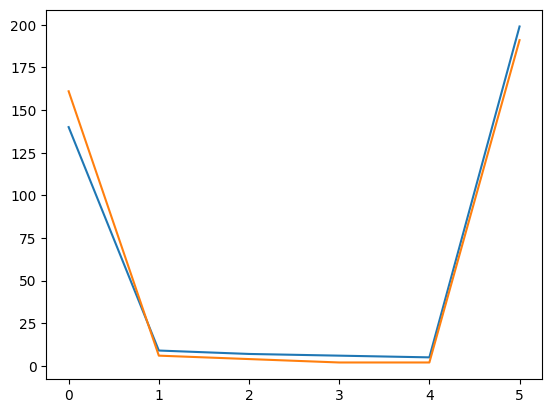

In [ ]:
plt.plot (train_env.steps_in_locomotion)
plt.plot (test_env.steps_in_locomotion)

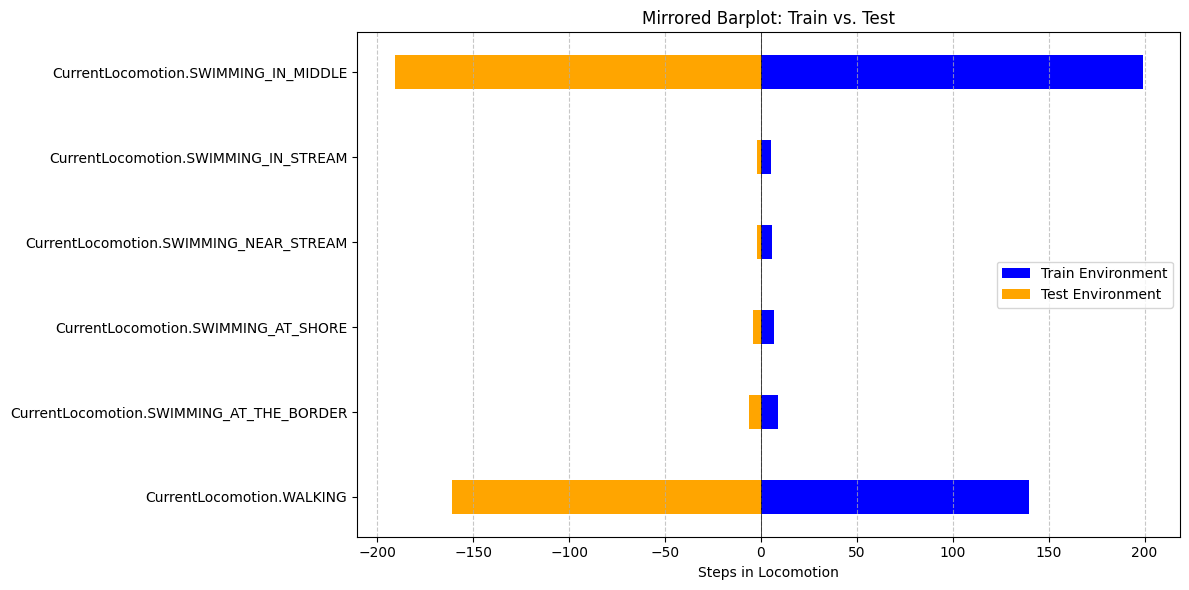

In [ ]:
# Beispiel-Daten
train_env_steps = np.array(train_env.steps_in_locomotion)  # Beispielwerte
test_env_steps = np.array(test_env.steps_in_locomotion)   # Beispielwerte
categories = CurrentLocomotion  # Kategorien

# Breite der Balken
bar_width = 0.4

# Erzeuge den Plot
fig, ax = plt.subplots(figsize=(12, 6))

# Position der Kategorien (y-Achse)
y_positions = np.arange(len(categories))

# Barplots: train_env_steps nach links und test_env_steps nach rechts
ax.barh(y_positions, train_env_steps, height=bar_width, color='blue', label='Train Environment')
ax.barh(y_positions, -test_env_steps, height=bar_width, color='orange', label='Test Environment')

# Achsenticks und Labels
ax.set_yticks(y_positions)
ax.set_yticklabels(categories)
ax.set_xlabel('Steps in Locomotion')
ax.set_title('Mirrored Barplot: Train vs. Test')
ax.legend()

# X-Achse spiegeln für die Test-Werte
ax.axvline(0, color='black', linewidth=0.5)  # Linie bei x=0

# Optional: Verbesserung der Lesbarkeit
ax.grid(axis='x', linestyle='--', alpha=0.7)

# Zeige den Plot
plt.tight_layout()
plt.show()


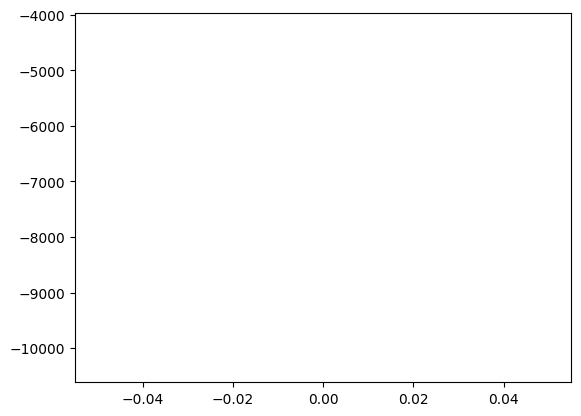

In [ ]:
plt.plot(train_rewards)
plt.plot(test_rewards);